# Preprocessing Techniques for Spectrograms

SciPy seems to have one of the most popular spectrogram generators,
it's documentation is found
[here]("https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.spectrogram.html").

SciPy also has a tool for reading .wav files found
[here]("https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html#scipy.io.wavfile.read").

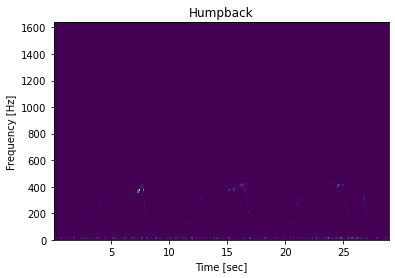

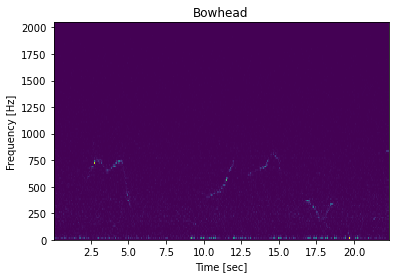

In [9]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

def plot_spectrogram(wav_file, spectrogram_title):
    """
    Plots a spectrogram of wav_file with title spectrogram_title
    :param wav_file: The .wav file to be plotted
    :param spectrogram_title: The title of the spectrogram to be plotted
    :return: a 2d ndarray of float32s which represents the spectrogram
    """
    sample_rate, samples = wavfile.read(wav_file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    plt.pcolormesh(times, frequencies, spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(spectrogram_title)
    plt.show()

    return spectrogram

humpback = plot_spectrogram('AU-AWBS04-141026-145051-40-DLW-humpback.wav', "Humpback")
bowhead = plot_spectrogram('AU-AWBF02-121025-010844-30-MAW-bowhead-song.wav', "Bowhead")

The bowhead call can be seen clearly in the above plot as the *M* shaped curves. The humpback's calls do not
stand out as readily, but are still visible especially in frequencies >400 Hz.

### Edge detection for cleaning data
From the above spectrogram, it seems possible that edge detection could be used to amplify
the call features.

Using
[canny edge detection]("https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html")

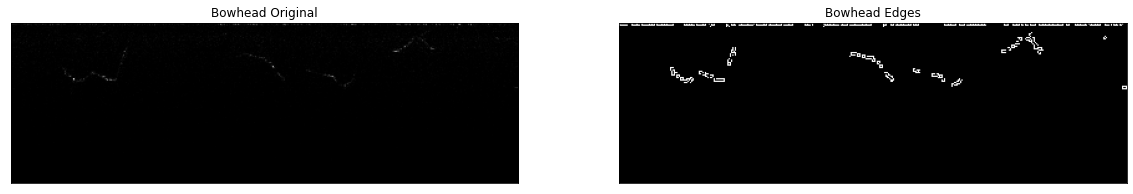

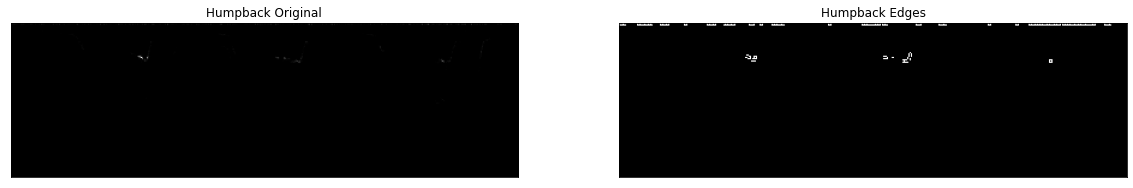

In [10]:
import cv2
import numpy as np

def to_cv2_compat(spectrogram):
    # Preprocess to correct format for opencv's library
    edge_image = spectrogram * (255.0 / spectrogram.max().item())
    return edge_image.astype(np.uint8)

def edge_find(image, image_name):
    """
    Generates an edge-detected image of 'image'
    :param image: an ndarray as returned by plot_spectrogram
    :param image_name: The image title for image
    :return: None
    """
    edge_image = to_cv2_compat(image)

    # Hysteresis thresholds are hand-picked and probably suboptimal
    edges = cv2.Canny(edge_image,25,95)
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.subplot(121),plt.imshow(edge_image,cmap = 'gray')
    plt.title('{} Original'.format(image_name)), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('{} Edges'.format(image_name)), plt.xticks([]), plt.yticks([])
    plt.show()

edge_find(bowhead, "Bowhead")
edge_find(humpback, "Humpback")

### Thresholding

Edge detection isn't terrible, but it appears that thresholding may do better.

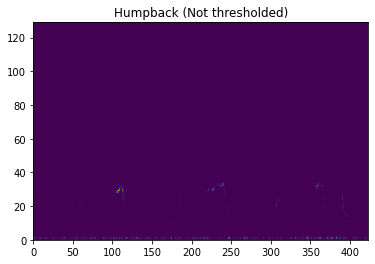

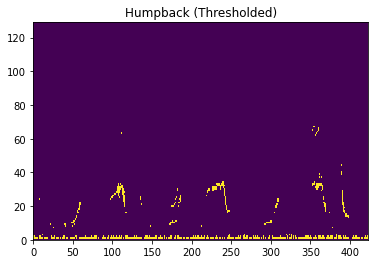

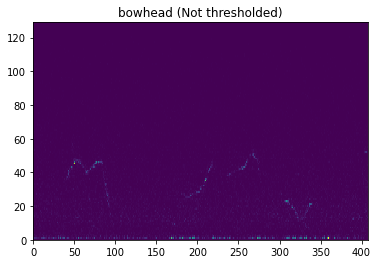

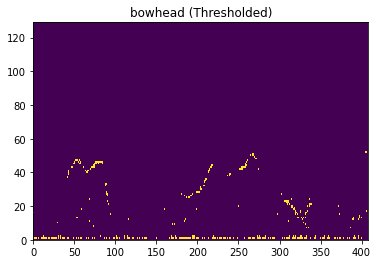

array([[      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ],
       [      0. , 2231608.8, 2231608.8, ...,       0. ,       0. ,
              0. ],
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ],
       ...,
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ],
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ],
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ]], dtype=float32)

In [11]:
import copy

def threshold(image, min_val, title, display=True):
    """
    Converts a continuous-valued image to a binary image by
    setting all pixels below min_val to 0 and all pixels
    above min_val to the maximum value in the image
    :param display: If true, then displays the image before and after
    thresholding. Otherwise, does not display image at all
    :param image: a numpy array of floats representing a grayscale image
    :param min_val: the minimum value desired for cutoff
    :param title: the title of the images which get displayed
    :return: The thresholded numpy array
    """
    if display:
        plt.pcolormesh(image)
        plt.title("{} (Not thresholded)".format(title))
        plt.show()

    # Set all values in image less than min_val to zero
    thresholded = copy.deepcopy(image)
    dropped_indices = thresholded < min_val
    thresholded[dropped_indices] = 0
    # set all values in image less than min_val to max_val
    kept_indices = thresholded >= min_val
    thresholded[kept_indices] = thresholded.max()

    if display:
        plt.pcolormesh(thresholded)
        plt.title("{} (Thresholded)".format(title))
        plt.show()

    return thresholded

# these min-values are hand-picked and likely sub-optimal
threshold(humpback, 100000, "Humpback")
threshold(bowhead, 120000, "bowhead")

Thresholding looks promising, but the process of choosing a threshold should
be automated:

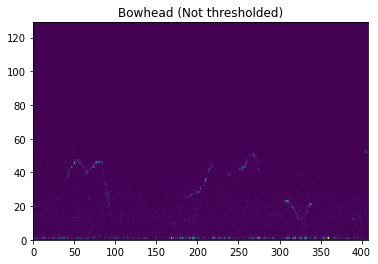

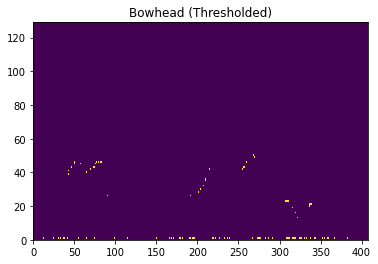

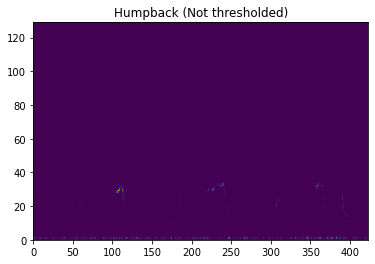

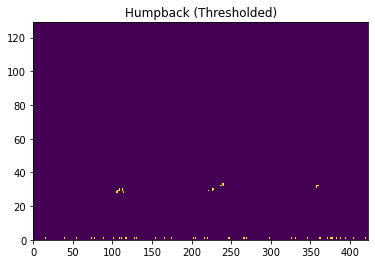

array([[       0.,        0.,        0., ...,        0.,        0.,
               0.],
       [14800687.,        0.,        0., ..., 14800687.,        0.,
               0.],
       [       0.,        0.,        0., ...,        0.,        0.,
               0.],
       ...,
       [       0.,        0.,        0., ...,        0.,        0.,
               0.],
       [       0.,        0.,        0., ...,        0.,        0.,
               0.],
       [       0.,        0.,        0., ...,        0.,        0.,
               0.]], dtype=float32)

In [12]:
def simple_automated_threshold(image):
    """
    Automates the process of picking a threshold for converting
    a spectrogram to binary. Not very good.
    :param image: The image for which a threshold is to be chosen
    :return: A reasonable threshold for turning the image to binary
    """
    thresh = image.mean()
    old_thresh = thresh + 1000

    while abs(old_thresh - thresh) > 1:
        below_thresh = image < thresh
        above_thresh = image >= thresh

        background_mean = image[below_thresh].mean()
        foreground_mean = image[above_thresh].mean()

        old_thresh = thresh
        thresh = float(background_mean + foreground_mean) / 2.0

    return thresh

threshold(bowhead, simple_automated_threshold(bowhead), "Bowhead")
threshold(humpback, simple_automated_threshold(humpback), "Humpback")

That didn't work super well. Another technique to consider is that which was employed by
T. Mitchell Aide et al in [https://peerj.com/articles/103/]("https://peerj.com/articles/103/").

> The algorithm to create the regions of interest (ROIs) starts by analyzing the frequency-time matrix to determine the level of background noise within each frequency band. This information is used to define thresholds of audio intensity that the input signals in the recording must surpass to be considered as an acoustic event. For each frequency band, we determine the mean intensity value and keep only the samples that are greater than 10% above the mean. This process greatly reduces the data, making it suitable for storing as a compressed sparse matrix (CSR). We analyze the CSR containing the acoustic events using a depth-first search algorithm to create neighborhoods of pixels into a single region of interest (ROI). Once, the sample is used in a ROI they are removed from the CSR and the algorithm selects another event until all samples that were selected as an acoustic event participates in a ROI. The time and frequency variables that describe the bounding box of each ROI (minimum and maximum frequency, duration, maximum intensity and bandwidth) are the variables that are later used to create the automated species identification algorithms.

In short, this approach is to:

1. Denoise the sample
1. Use a search algorithm to find noise islands in the denoised sample

Building on top of the same ideas as presented in the block quote above:

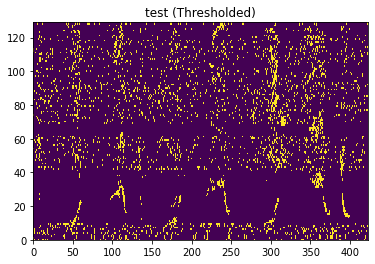

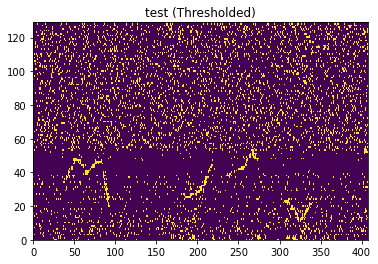

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
def denoise(image):
    denoised_img = copy.deepcopy(image)

    for row in denoised_img:
        mean = row.mean()
        std_dev = row.std()

        # Select the top 10 percent
        dropped_indices = row < mean + std_dev
        row[dropped_indices] = 0
        row[np.invert(dropped_indices)] = 1

    plt.pcolormesh(denoised_img)
    plt.title("{} (Thresholded)".format("test"))
    plt.show()

    return denoised_img

denoise(humpback)
denoise(bowhead)

The technique didn't eliminate noise, however, it *did* conserve nearly all of the useful information
from the two spectrograms. Therefore, the search-algorithm approach to finding useful partitions is worth
pursuing.

